# Topic modeling
## [Dataset](https://archive.org/details/120_tysyach_anekdotov)

In [3]:
!pip list | grep protobuf

protobuf                  4.25.1            


In [309]:
# ! pip install wordcloud

     |████████████████████████████████| 520 kB 1.3 MB/s eta 0:00:01


In [12]:
# !pip install protobuf==3.20

In [167]:
# !pip install bigartm

In [77]:
# !pip install umap-learn

In [311]:
import re
import os
import pandas as pd
import numpy as np
import nltk
import pymorphy2
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm, trange
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import artm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings

In [2]:
# os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Text preprocessing

In [17]:
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("bright")
tqdm.pandas()

In [17]:
with open("anek_djvu.txt", mode="r") as f:
    txt_list = [txt.replace("<|startoftext|>","") for txt in f]

In [25]:
df = pd.DataFrame({"text":txt_list})
df = df[df.text!="\n"]
df.shape

(124166, 1)

In [27]:
df.head()

,text
0,"Только заметил, что слово ""п@рно"" набирается с..."
2,"Друзья мои, чтобы соответствовать вам, я готов..."
4,"- Люся, ты все еще хранишь мой подарок?- Да.- ..."
6,"- А вот скажи честно, ты во сне храпишь?- Поня..."
8,"Поссорилась с мужем. Пока он спал, я мысленно ..."


In [99]:
def text_normalize(txt):
    tmp_txt = " ".join(re.findall(r"[а-яa-z@]+", txt.lower()))
    return tmp_txt

In [100]:
df["text_norm"] = df.apply(lambda x: text_normalize(x.text), axis=1)

In [101]:
df.head()

,text,text_norm,syms
0,"Только заметил, что слово ""п@рно"" набирается с...",только заметил что слово п@рно набирается сами...,"[ , , , ,, , , , , , "", , @, , "", , ..."
2,"Друзья мои, чтобы соответствовать вам, я готов...",друзья мои чтобы соответствовать вам я готов с...,"[ , , , ,, , , , , , , ,, , , , , ..."
4,"- Люся, ты все еще хранишь мой подарок?- Да.- ...",люся ты все еще хранишь мой подарок да я думал...,"[-, , , ,, , , , , , , , , , , , ..."
6,"- А вот скажи честно, ты во сне храпишь?- Поня...",а вот скажи честно ты во сне храпишь понятие н...,"[-, , , , , , , , , ,, , , , , , ..."
8,"Поссорилась с мужем. Пока он спал, я мысленно ...",поссорилась с мужем пока он спал я мысленно ра...,"[ , , , , , ., , , , , , , ,, , , ..."


In [518]:
morph = pymorphy2.MorphAnalyzer()
stopwords = nltk.corpus.stopwords.words("russian")

In [516]:
def lematize(txt, morph, stopwords):
    # addit = ['наш', 'ваш', 'твой', 'свой', 'это']
    # stop_rus.extend(addit)
    tmp_txt = ' '.join([morph.parse(word)[0].normal_form for word in txt.split() if word not in stopwords])
    return tmp_txt

In [519]:
df["text_lemm"] = df.progress_apply(lambda x: lematize(x.text_norm, morph, stopwords), axis=1)

100%|█████████████████████████████████| 124166/124166 [01:56<00:00, 1068.80it/s]


In [520]:
df.head()

,text,text_norm,syms,text_lemm
0,"Только заметил, что слово ""п@рно"" набирается с...",только заметил что слово п@рно набирается сами...,"[' ', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",заметить слово п@рно набираться сам центральны...
1,"Друзья мои, чтобы соответствовать вам, я готов...",друзья мои чтобы соответствовать вам я готов с...,"[' ', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",друг мой соответствовать готовый сделать себя ...
2,"- Люся, ты все еще хранишь мой подарок?- Да.- ...",люся ты все еще хранишь мой подарок да я думал...,"['-', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",люся хранить подарок думать выкинуть я связать...
3,"- А вот скажи честно, ты во сне храпишь?- Поня...",а вот скажи честно ты во сне храпишь понятие н...,"['-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ...",сказать честно сон храпеть понятие иметь вроде...
4,"Поссорилась с мужем. Пока он спал, я мысленно ...",поссорилась с мужем пока он спал я мысленно ра...,"[' ', ' ', ' ', ' ', ' ', '.', ' ', ' ', ' ', ...",поссориться муж пока спасть мысленно развестис...


## Load LaBSE

In [67]:
LABSE_REMOTE_PATH = "sentence-transformers/LaBSE"
LABSE_LOCAL_PATH = "LaBSE"

In [68]:
labse_model = AutoModel.from_pretrained(LABSE_LOCAL_PATH)
labse_tokenizer = AutoTokenizer.from_pretrained(LABSE_LOCAL_PATH)

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [70]:
labse_model = labse_model.to(device)

In [135]:
df["tokens_len"] = df.progress_apply(lambda x: len(labse_tokenizer(x.text_lemm).input_ids), axis=1)

100%|████████████████████████████████| 124166/124166 [00:12<00:00, 10255.35it/s]


In [136]:
df.tokens_len.max()

92

# Get embeddings from LaBSE

In [523]:
def text2emb(text, model, tokenizer, max_len):
    embs = []
    model.eval()
    with torch.no_grad():
        for txt in tqdm(text):
            token_input = tokenizer(txt, 
                                    max_length=max_len,
                                    padding="max_length",
                                    return_tensors="pt")
            tmp_emb = model(**{k:v.to(model.device) for k, v in token_input.items()}).pooler_output
            tmp_emb_norm = torch.nn.functional.normalize(tmp_emb).detach().cpu().numpy()
            embs.append(tmp_emb_norm[0])
    return embs

In [91]:
def get_sentense_emb(text, model, tokenizer, max_len):
    embs = []
    model.eval()
    with torch.no_grad():
        for txt in tqdm(text):
            token_input = tokenizer(txt, 
                                    max_length=max_len,
                                    padding="max_length",
                                    return_tensors="pt")
            tmp_emb = model(**{k:v.to(model.device) for k, v in token_input.items()}).last_hidden_state
            mask = token_input['attention_mask'].to(model.device).unsqueeze(-1).expand(tmp_emb.size()).float()
            masked_embeddings = tmp_emb * mask
            summed = torch.sum(masked_embeddings, 1)
            counted = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / counted
            embs.append(mean_pooled.detach().cpu().numpy()[0])
    return embs

In [521]:
lemm_txt_list = list(df.text_lemm)

In [525]:
# labse_emb_name = text2emb(lemm_txt_list, labse_model, labse_tokenizer, 100)

In [92]:
sentense_labse_emb = get_sentense_emb(top_txt, labse_model, labse_tokenizer, 100)

100%|████████████████████████████████████| 10000/10000 [01:08<00:00, 145.52it/s]


In [93]:
sentense_labse_emb = np.array(sentense_labse_emb)
with open("sentense_labse_embeddings.pkl", "wb") as f:
    pickle.dump(sentense_labse_emb, f)

In [149]:
labse_emb = np.array(labse_emb)

In [152]:
# with open("labse_embeddings.pkl", "wb") as f:
#     pickle.dump(labse_emb, f)

In [46]:
def get_most_sim(etalon, emb, n_=5):
    dist = []
    for x in emb:
        dist.append(cos_sim(etalon, x))
    idxs = np.argsort(dist)[::-1][:n_]
    return np.array(dist)[idxs], idxs

In [4]:
with open("labse_embeddings.pkl", "rb") as f:
    labse_emb = pickle.load(f)

# Clustering

In [5]:
df = pd.read_csv("anek_norm.csv", dtype="O")
df.shape

(124166, 4)

In [6]:
TOP_N = 10000
top_emb = labse_emb[:TOP_N]
top_txt = list(df.text.iloc)[:TOP_N]

In [147]:
# hdbscan = HDBSCAN(min_cluster_size=100, metric="euclidean").fit(umap_emb)

In [149]:
# unique, counts = np.unique(hdbscan.labels_, return_counts=True)

In [136]:
umap_emb = UMAP(n_neighbors=20, n_components=192, metric='euclidean').fit_transform(top_emb)

In [7]:
# sns.scatterplot(x=umap_emb[:,0], y=umap_emb[:,1], hue=hdbscan.labels_)

## Dimensionality reduction with autoencoder

In [114]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(*[torch.nn.Linear(768,384), torch.nn.SiLU(), 
                                             torch.nn.Linear(384, 192), torch.nn.SiLU()])
        self.decoder = torch.nn.Sequential(*[torch.nn.Linear(192, 384), torch.nn.SiLU(),
                                             torch.nn.Linear(384,768)])
   
    def forward(self, emb):
        out = self.encoder(emb)
        out = self.decoder(out)
        return out

In [ ]:
train_emb, test_emb = train_test_split(top_emb, random_state=42)

train_dataset = torch.utils.data.DataLoader(train_emb, batch_size=8)
test_dataset = torch.utils.data.DataLoader(test_emb, batch_size=8)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [64]:
def train(model, device, train_dataloader, test_dataloader, optim, loss_func, epochs, log_every=10):
    for epoch in range(epochs):
        model.train()
        train_loss = torch.tensor([], dtype=torch.float32, device=device)
        if epoch % log_every==0:
            print(f"{'='*10}Start epoch {epoch} {'='*10}")
        for batch in train_dataloader:
            batch = batch.to(device)
            out = model(batch)
            loss = loss_func(out, batch)
            train_loss = torch.concat([train_loss, torch.tensor([loss.item()], dtype=torch.float32, device=device)])
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % log_every==0:
            print(f"Train Loss: {train_loss.mean().item()}")

        model.eval()
        with torch.no_grad():
            eval_loss = torch.tensor([], dtype=torch.float32, device=device)
            for batch in test_dataloader:
                batch = batch.to(device)
                out = model(batch)
                loss = loss_func(out, batch)
                eval_loss = torch.concat([eval_loss, torch.tensor([loss.item()], dtype=torch.float32, device=device)])
        if epoch % log_every==0:
            print(f"Eval Loss: {eval_loss.mean().item()}")

In [115]:
autoencoder = AutoEncoder().to(device)
opt = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4, weight_decay=1e-3)
loss_fn = torch.nn.MSELoss()
train(autoencoder, device, train_dataset, test_dataset, opt, loss_fn, 100)

==========Start epoch 0 ==========
Train Loss: 0.0006636808393523097
Eval Loss: 0.00041676833643577993
==========Start epoch 10 ==========
Train Loss: 6.159958138596267e-05
Eval Loss: 6.085081986384466e-05
==========Start epoch 20 ==========
Train Loss: 3.957587978220545e-05
Eval Loss: 4.044105298817158e-05
==========Start epoch 30 ==========
Train Loss: 3.373528306838125e-05
Eval Loss: 3.473446849966422e-05
==========Start epoch 40 ==========
Train Loss: 3.0868748581269756e-05
Eval Loss: 3.2130959880305454e-05
==========Start epoch 50 ==========
Train Loss: 2.9931277822470292e-05
Eval Loss: 3.13037344312761e-05
==========Start epoch 60 ==========
Train Loss: 2.914283140853513e-05
Eval Loss: 3.051460771530401e-05
==========Start epoch 70 ==========
Train Loss: 2.8905866201967e-05
Eval Loss: 3.0300272555905394e-05
==========Start epoch 80 ==========
Train Loss: 2.8737731554429047e-05
Eval Loss: 3.015780202986207e-05
==========Start epoch 90 ==========
Train Loss: 2.860400672943797e-05
E

In [116]:
encoded_features = np.array([autoencoder.encoder(torch.tensor(x, dtype=torch.float32, device=device))\
                                 .detach().cpu().numpy() for x in top_emb])

In [159]:
# with open("encoded_features.pkl", "wb") as f:
#     pickle.dump(encoded_features, f)

In [139]:
# n__ = 532
# n_txt = top_txt[n__]
# e_emp = encoded_features[n__]
# e_e_emp = top_emb[n__]
# umao_e = umap_emb[n__]

# most_sim_sims, most_sim_idx = get_most_sim(e_emp, encoded_features)
# most_sim_e, most_idx_e = get_most_sim(e_e_emp, top_emb)
# most_sim_umap, most_sim_umap_idx = get_most_sim(umao_e, umap_emb)

In [140]:
# for i in most_sim_idx:
#     print(top_txt[i])

In [141]:
# for i in most_idx_e:
#     print(top_txt[i])

## Clustering encoded features

In [8]:
def get_opt_clusters(X, n_clusters):
    inertia, sil = [], []
    for i in trange(2, n_clusters):
        tmp_kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
        tmp_labels = tmp_kmeans.labels_
        inertia.append(tmp_kmeans.inertia_)
        sil.append(silhouette_score(X, tmp_labels, metric="cosine"))
    return inertia, sil

In [142]:
tmp_inertia, tmp_sil = get_opt_clusters(encoded_features, 30)

100%|███████████████████████████████████████████| 28/28 [01:11<00:00,  2.57s/it]


In [143]:
def get_top_sil(sil, n_start=2, top_k = 5):
    top_args = np.argsort(sil)[::-1][:top_k]
    top_sils = np.array(sil)[top_args]
    print(top_args+n_start)
    print(top_sils)

In [144]:
def get_top_kmeans(X, n_clusters):
    tmp_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    tmp_labels = tmp_kmeans.labels_
    print(silhouette_score(X, tmp_labels, metric="cosine"))
    return tmp_kmeans

In [145]:
def cos_sim(x,y):
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [146]:
def get_centroid(X, centers):
    c_idx = []
    for tmp_c in centers:
        tmp_dist = [cos_sim(tmp_c, v) for v in X]
        c_idx.append(np.argmax(tmp_dist))
    return c_idx

In [147]:
def plot_inertia(inertia):
    plt.figure(figsize=(5,5))
    plt.plot(inertia, 'bx-')
    plt.title('Finding right number of clusters')
    plt.xlabel('Clusters')
    plt.ylabel('scores') 
    plt.show()

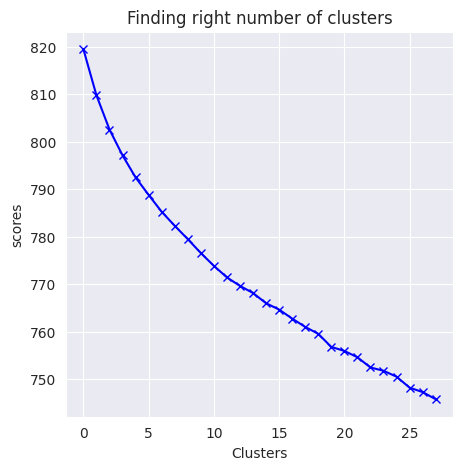

In [148]:
plot_inertia(tmp_inertia)

In [150]:
get_top_sil(tmp_sil)

[27 23 22 21 19]
[0.04070722 0.04067258 0.04014203 0.03954615 0.03943399]


In [151]:
top_kmeans = get_top_kmeans(encoded_features, 27)

0.040707216


In [152]:
top_centers = top_kmeans.cluster_centers_
top_centers_idx = get_centroid(encoded_features, top_centers)

In [153]:
top_df = df.iloc[:TOP_N]
top_df["labels"] = top_kmeans.labels_
top_df["centroid_idx"] = top_df.apply(lambda x: top_centers_idx[x.labels], axis=1)
top_df["centroid_txt"] = top_df.apply(lambda x: top_txt[x.centroid_idx], axis=1)

In [154]:
top_df.head()

,text,text_norm,syms,text_lemm,labels,centroid_idx,centroid_txt
0,"Только заметил, что слово ""п@рно"" набирается с...",только заметил что слово п@рно набирается сами...,"[' ', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",заметить слово п@рно набираться сам центральны...,12,6777,Утка входит в пивную и обращается к бармену:- ...
1,"Друзья мои, чтобы соответствовать вам, я готов...",друзья мои чтобы соответствовать вам я готов с...,"[' ', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",друг мой соответствовать готовый сделать себя ...,23,3551,"У них - человек то, что он ест, у нас - челове..."
2,"- Люся, ты все еще хранишь мой подарок?- Да.- ...",люся ты все еще хранишь мой подарок да я думал...,"['-', ' ', ' ', ',', ' ', ' ', ' ', ' ', ' ', ...",NAME хранить подарок думать выкинуть я связать...,20,2577,Он вам не Димон! Теперь он Дима-разнотык.\n
3,"- А вот скажи честно, ты во сне храпишь?- Поня...",а вот скажи честно ты во сне храпишь понятие н...,"['-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ...",сказать честно сон храпеть понятие иметь вроде...,4,4291,Прозвенел будильник. Я проснулся. Встал и поше...
4,"Поссорилась с мужем. Пока он спал, я мысленно ...",поссорилась с мужем пока он спал я мысленно ра...,"[' ', ' ', ' ', ' ', ' ', '.', ' ', ' ', ' ', ...",поссориться муж пока спасть мысленно развестис...,11,2153,Ссорится жена с мужем. Жена:- Лучше бы вышла з...


In [155]:
CHECK_CLUSTER = 1
top_df[top_df.labels==CHECK_CLUSTER]["centroid_txt"].iloc[0]

'Кто не курит и не пьет, тот невеселый и трезвый.\n'

In [160]:
for i in range(10):
    print(top_df[top_df.labels==CHECK_CLUSTER]["text"].iloc[i])

Когда-то запретили пить водку - и рухнул великий Советский Союз. Сейчас запретили в соцсетях говорить матом...

Курить конечно вредно, вон у меня один сосед от рака легкого умер, а другой сосед пьяный заснул, оставив незатушенной сигарету, начался пожар и весь подъезд разнесло взрывом газа. Хорошо, что я в это время за куревом в магазин пошел.

Наорал на сковородку, которая начала стрелять в меня маслом. Могу теперь с уверенностью сказать, что сковородка не понимает криков.

Сядьте на диету, откажитесь от алкоголя, перестаньте есть после шести вечера, и за две недели потеряете 14 дней веселой жизни.

Наконец-то вышел из депрессии. Постоял, покурил, вошел обратно.

Как посмотришь, что кругом творится - впору водке дешеветь!

Уровень дофамина достигает максимума во время еды и секса, а уровень серотонина - при потреблении сладостей. Так что если одновременно жрать шоколадку и тр@хаться, то вас может разорвать от счастья. Берегите себя.

Готовить - это просто. Идет пар - готовится. Пошел 

In [161]:
# top_df.to_csv("with_clusters.csv", index=False)

In [317]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud) 
    plt.axis("off")

def make_wc(txt):
    wordcloud = WordCloud(width = 2000, 
                          height = 1500, 
                          random_state=1, 
                          background_color='black', 
                          margin=20, 
                          colormap='Pastel1', 
                          collocations=False, 
                          ).generate(txt)
    return wordcloud

In [344]:
one_cluster = "\n".join(list(top_df[top_df.labels==10]["text_lemm"]))
second_cluster = "\n".join(list(top_df[top_df.labels==25]["text_lemm"]))

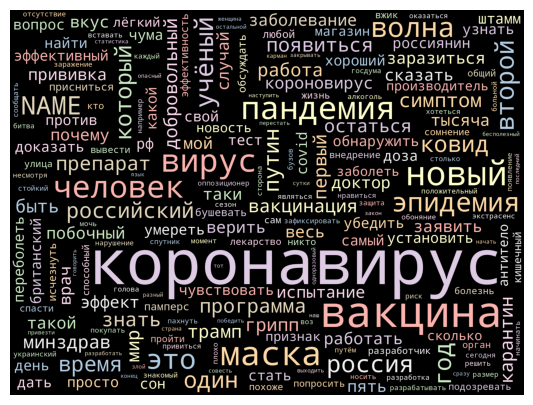

In [345]:
wordcloud_two = make_wc(second_cluster) 

plot_cloud(wordcloud_two)

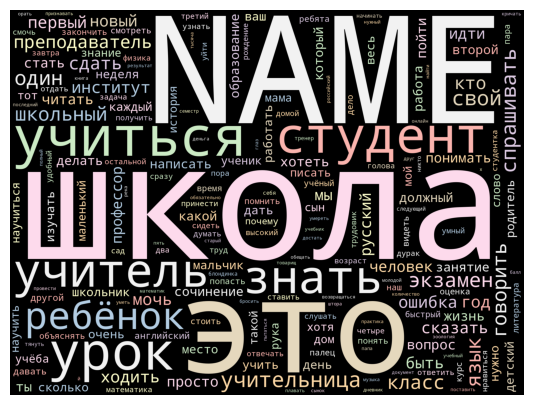

In [321]:
wordcloud_one = make_wc(one_cluster) 

plot_cloud(wordcloud_one)

# Use BigARTM for each cluster

In [162]:
# one_cluster_txt = list(top_df[top_df.labels==2]["text_lemm"])

In [166]:
def to_vw_format(document):
    return "|text" + " ".join(word for word in document.split()) 

In [228]:
one_cluster_txt = list(top_df[top_df.labels==10]["text_lemm"].apply(to_vw_format))
len(one_cluster_txt)

253

In [229]:
one_cluster_txt[:5]

['|textслава понимать разгон митинг должный действовать жёстко явно перебарщивать ясно видеть садистский наклонность мутузить ребёнок кстати омон работать год школьный учитель',
 '|textновый награда росгвардия медаль взятие студент',
 '|textтеория учить смотреть далеко вперёд практика нога',
 '|textэто рука электронный книга пытаться бросить читать',
 '|textсмотреть сынок быть учиться купить ты компьютер быть плохо учиться пианино']

In [231]:
with open("documents.txt", mode="w") as f:
    for tmp_txt in one_cluster_txt:
        f.write(tmp_txt + '\n')

In [238]:
batch_vectorizer = artm.BatchVectorizer(data_path="documents.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="batch_vectorizer", 
                                        batch_size=100)

In [292]:
T = 30   # number of topics
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

In [235]:
# # np.random.seed(1)
# dictionary = artm.Dictionary('dict')
# dictionary.gather(batch_vectorizer.data_path)
# model.initialize(dictionary=dictionary)

In [222]:
# batch_vect = artm.BatchVectorizer(data_path="documents.txt",
#                                   data_format="vowpal_wabbit",
#                                   target_folder="batch_vect")

In [293]:
dict = artm.Dictionary()
dict.gather(data_path='batch_vectorizer')
dict.save_text(dictionary_path='batch_vectorizer/my_dict.txt')

In [173]:
# dict.filter(min_tf=int, max_tf=int)

In [294]:
theme_mod = artm.ARTM(num_topics = 10, dictionary=dict, cache_theta= True) #theta – матрица вероятностей принадлежности каждого текста каждой тематике
theme_mod.scores.add(artm.PerplexityScore(name='my_first_perplexity_score', dictionary=dict)) #метрика оценки модели – перплексия
theme_mod.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=5)) #метрика оценки модели – топ 5 (num_tokens) слов  по каждой тематике

In [295]:
theme_mod.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

In [307]:
# theme_mod.num_document_passes = 1
# theme_mod.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

In [308]:
topic_names_cleaned = topic_names[:-1]

In [298]:
theme_mod.initialize(dictionary=dict)
theme_mod.fit_offline(batch_vectorizer=batch_vect, num_collection_passes=20)

In [299]:
theme_mod.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleaned))

In [300]:
theme_mod.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

In [301]:
for theme in theme_mod.topic_names:
  print(theme + ": ")
  print(theme_mod.score_tracker['TopTokensScore'].last_tokens[theme])

topic_0: 
['работа', 'другой', 'писать', 'мама', 'дело']
topic_1: 
['школа', 'свой', 'понимать', 'пойти', 'работать']
topic_2: 
['знать', 'спрашивать', 'человек', 'хотя', 'литература']
topic_3: 
['кто', 'новый', 'написать', 'который', 'должный']
topic_4: 
['ходить', 'мы', 'ты', 'очень', 'день']
topic_5: 
['это', 'класс', 'один', 'сдать', 'ошибка']
topic_6: 
['учительница', 'читать', 'стать', 'жизнь', 'хотеть']
topic_7: 
['ребёнок', 'первый', 'мочь', 'год', 'второй']
topic_8: 
['NAME', 'учиться', 'быть', 'ваш', 'английский']
topic_9: 
['говорить', 'просто', 'такой', 'палец', 'дурак']


In [302]:
test = theme_mod.get_theta().transpose()
#test["txt"] = list(top_df[top_df.labels==1]["text"])

In [303]:
test["cluster"] = test.apply(lambda x: np.argmax(x.values), axis=0)

In [304]:
one_cluster_txt[3]

'|textэто рука электронный книга пытаться бросить читать'

In [305]:
test.loc[245]

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,cluster
245,0.000068,0.918921,0.005762,0.043589,0.000002,2.498030e-11,0.005772,2.140704e-11,1.812964e-14,0.025887,NaN
245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000e+00,0.000000,NaN


In [306]:
len(theme_mod.score_tracker["my_first_perplexity_score"].value)

100

In [284]:
print(theme_mod.score_tracker['my_fisrt_perplexity_score'].value)

KeyError: 'my_fisrt_perplexity_score'

In [278]:
test.tail(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
243,8.333334e-02,0.416667,0.000000,0.083333,0.166667,0.000000e+00,0.000000,0.166667,0.083333,0.000000e+00
244,0.000000e+00,0.200000,0.200000,0.200000,0.200000,0.000000e+00,0.000000,0.000000,0.200000,0.000000e+00
245,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000e+00
246,0.000000e+00,0.166667,0.333333,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.333333,1.666667e-01
247,1.428571e-01,0.142857,0.285714,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.285714,1.428571e-01
248,8.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.200000,0.000000e+00
249,1.032246e-07,0.000000,0.000000,0.500000,0.500000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
250,0.000000e+00,0.000000,0.000000,0.000000,0.333331,3.333352e-01,0.000000,0.333333,0.000000,5.977294e-11
251,0.000000e+00,0.000000,0.000000,0.000000,0.333333,2.030317e-11,0.000000,0.000000,0.333333,3.333333e-01
252,6.801178e-02,0.000000,0.260870,0.000000,0.000000,1.304348e-01,0.100592,0.266178,0.130435,4.347826e-02


# Articles
+ ### [BigARTM – тематическое моделирование на Python](https://newtechaudit.ru/bigartm-tematicheskoe-modelirovanie-na-python/)
+ ### [Тематическое моделирование с использованием эмбеддингов BERT](https://habr.com/ru/articles/653443/)
+ ### [Как и зачем мы начали искать бизнес-инсайты в отзывах клиентов с помощью машинного обучения](https://habr.com/ru/companies/alfa/articles/684774/)

# Notebooks
+ ### [Bigartm. Thematic modeling](https://www.kaggle.com/code/amina888/bigartm-thematic-modeling/notebook)

# Docs
+ ### [Welcome to BigARTM’s documentation!](https://docs.bigartm.org/en/latest/index.html)